In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.drop(columns=df.columns[0], inplace=True)
df

,date,time,price
0,20150105,100100,1064.0
1,20150105,100200,1064.0
2,20150105,100300,1064.0
3,20150105,100400,1064.0
4,20150105,100500,1064.0
...,...,...,...
262103,20161230,183800,1248.5
262104,20161230,183900,1248.5
262105,20161230,184000,1248.5
262106,20161230,184600,1247.5


In [3]:
# логарифмируем цену, чтобы изменение цены вычислять в процентах
# df.price[y] / df.price[x] = np.exp(log_price[y] - log_price[x])
log_price = np.log(df.price)

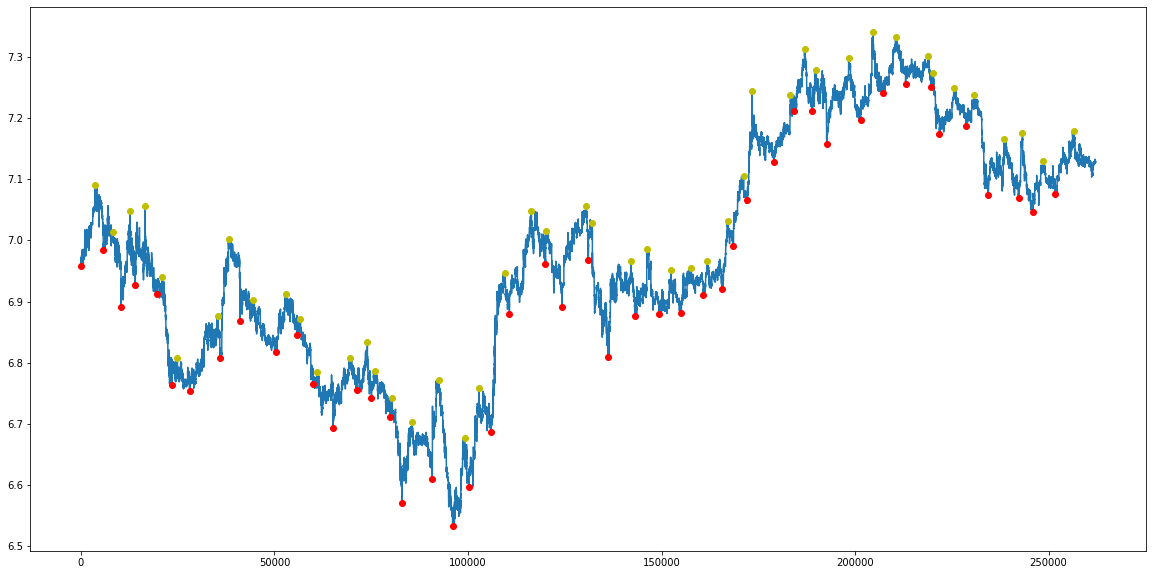

In [4]:
# находим точки максимума и минимума
x_min = []
x_max = []
x = []
N = 4000
for i in range(len(df.price) // N):
    x_max.append(N * i + log_price[N * i:N * (i + 1)].argmax())
    x_min.append(N * i + log_price[N * i:N * (i + 1)].argmin())
    for k in sorted([x_max[-1], x_min[-1]]):
        x.append(k)

# выбираем среди подряд идущих максимумов (минимумов) одну максимальную (минимальную)
for i in range(len(x) - 1):
    if (x[i] in x_max and x[i + 1] in x_max):
        if (log_price[x[i]] < log_price[x[i + 1]]):
            x_max.remove(x[i])
        else:
            x_max.remove(x[i + 1])

    if (x[i] in x_min and x[i + 1] in x_min):
        if (log_price[x[i]] < log_price[x[i + 1]]):
            x_min.remove(x[i + 1])
        else:
            x_min.remove(x[i])

x_min = x_min[:min(len(x_min), len(x_max))]
x_max = x_max[:min(len(x_min), len(x_max))]

f_max = []
f_min = []
for i in range(len(x_max)):
    f_max.append(log_price[x_max[i]])
    f_min.append(log_price[x_min[i]])

# отрисовка точек максимума и минимума
plt.figure(figsize=(20, 10))
log_price.plot()
plt.plot(x_max, f_max, 'yo')
plt.plot(x_min, f_min, 'ro')

In [5]:
def plot_price_surge(price=log_price, x_max=x_max, x_min=x_min):
    """
    Функция, отрисовывающая линии, соединяющие точки покупки и продажи акций
    :param price: pd.Series - массив логарифма цен на акцию за все время
    :param x_max: list - массив точек максимума
    :param x_min: list - массив точек минимума
    """
    plt.figure(figsize=(20, 10))
    log_price.plot()

    f_max = []
    f_min = []

    for i in range(len(x_max)):
        f_max.append(log_price[x_max[i]])
        f_min.append(log_price[x_min[i]])

    plt.plot(x_max, f_max, 'yo')
    plt.plot(x_min, f_min, 'ro')
    for i in range(len(x_max)):
        plt.plot([x_min[i], x_max[i]], [log_price[x_min[i]], log_price[x_max[i]]], linewidth=3)

In [6]:
X_min = deepcopy(x_min)
X_max = deepcopy(x_max)


def get_min_dif(price=log_price, x_max=X_max, x_min=X_min):
    """
    Функция, которая находит пару (максимум; минимум) с наимаеньшей
    разностью цен покупки и продажи
    :param price: pd.Series - массив логарифма цен на акцию за все время
    :param x_max: list - массив точек максимума
    :param x_min: list - массив точек минимума
    :return: int, int - индекс для пары точек, с наимаеньшей разностью
    между максимумом и минимумом, количество оставшихся точек
    """
    dif = []

    for i in range(len(x_max)):
        dif.append([log_price[x_max[i]] - log_price[x_min[i]], i])
    return min(dif, key=lambda x: x[0])[1], len(dif)


def get_nearest(price, x_min, i):
    """
    Функция, которая находит ближайшую по точке минимума пару (максимум; минимум)
    :param price: pd.Series - массив логарифма цен на акцию за все время
    :param x_min: list - массив точек минимума
    :param i:int - индекс текущей точки
    :return: индекс ближайшей точки
    """
    # выбираем ближайшее по x_min и штрафуем за изменение высоты
    dist_right = abs(x_min[i] - x_min[i + 1]) + 10**5 * abs(price[x_min[i]] - price[x_min[i + 1]])
    dist_left = abs(x_min[i] - x_min[i - 1]) + 10**5 * abs(price[x_min[i]] - price[x_min[i - 1]])

    if dist_right < dist_left:
        return i + 1
    else:
        return i - 1


def get_best(x, i, i_alt, func):
    """
    Функция, которая выбирает лучшую из двух точек
    :param x: list - массив, точки которого сравниваются
    :param i: int индекс текущей точки
    :param i_alt: индекс (альтернативной) точки, с которой сравниваем текущую
    :param func: int, int -> bool функция, сравнивающая 2 точки
    :return: индекс лучшей точки
    """
    if func(x[i], x[i_alt]):
        return i
    else:
        return i_alt

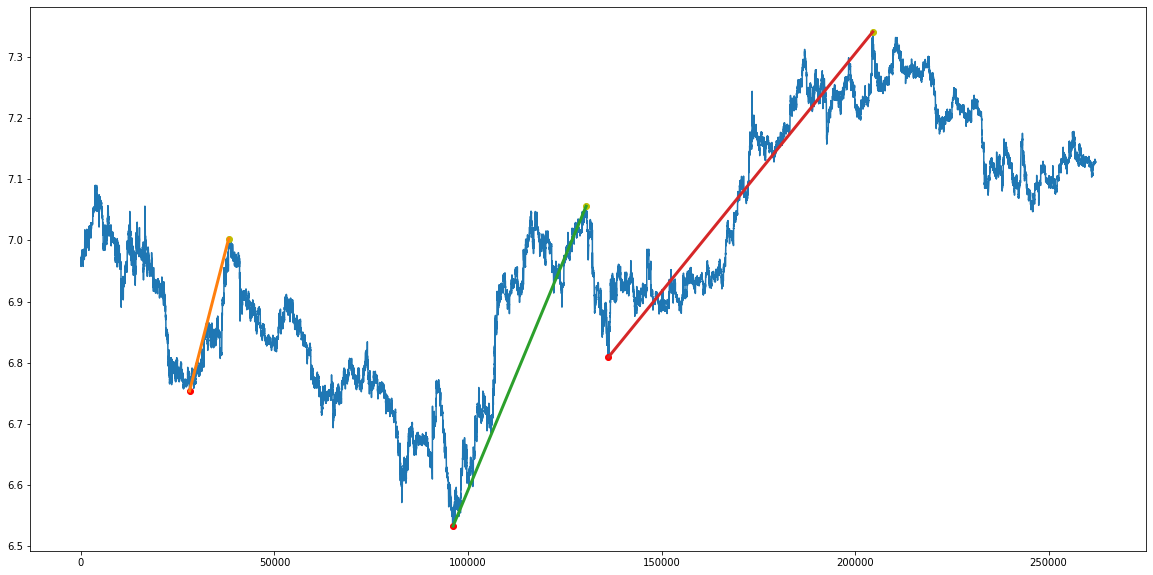

In [7]:
k = 3  # количество транзакций
diff = get_min_dif()

while diff[1] > k:

    indx = diff[0]
     
     # выбираем ближайшую точку, обрабатываем крайние точки
    if (indx == 0):
        x_nearest = indx + 1
    elif(indx == len(X_max) - 1):
        x_nearest = indx - 1
    else:
        x_nearest = get_nearest(log_price, X_min, indx)

    ind_min_best = get_best(X_min, indx, x_nearest, lambda x, x_alt: log_price[x] < log_price[x_alt])
    x_min_best = X_min[ind_min_best]

    # удаляем худшую из 2 точек: текущей и альтернативной ближайшей
    if (x_nearest < indx and ind_min_best == indx):
        X_min.pop(indx)
        X_max.pop(indx)
    else:
        if (ind_min_best == indx):
            X_min.pop(x_nearest)
        else:
            X_min.pop(indx)

        if (X_max[indx] > x_min_best and X_max[x_nearest] > x_min_best):

            if (indx == get_best(X_max, indx, x_nearest, lambda x, x_alt: log_price[x] > log_price[x_alt])):
                X_max.pop(x_nearest)
            else:
                X_max.pop(indx)
        elif (X_max[x_nearest] > x_min_best):
            X_max.pop(indx)
        else:
            X_max.pop(x_nearest)

    diff = get_min_dif()

plot_price_surge(x_min=X_min, x_max=X_max)